## Example 1. Drawing Convergence Figure

Below cell is equivalent with the following command:

```bash
python main.py --study_type convergence --dataset_name adult --metrics t:ge_bar_trace --metrics t:err_bar_trace --lambda_max 20.0 --nu 0.01 --alpha 0.0 --gamma 0.04 --c 8.0 --a 5.0
```

=== ParamSet(lambda_max=20.0, nu=0.01, alpha=0.0, gamma=0.04, c=8.0, a=5.0) ===


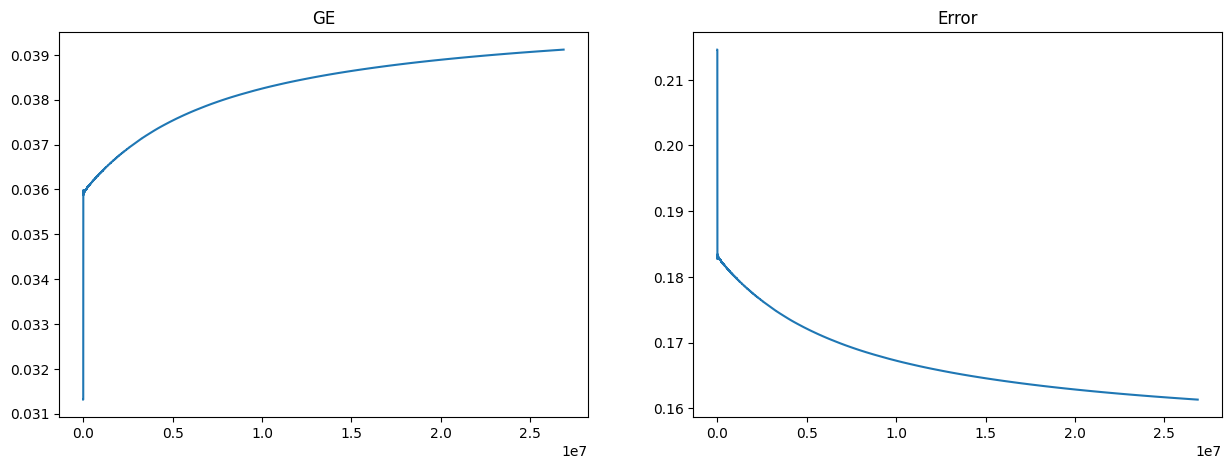

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.typing import NDArray

from datasets.adult import Adult
from fermge import BinaryLogisticClassification, run_exp
from plotting import resample_for_plotting

group_size = 2
blc_max_iter = 100
param_dict = {
    "lambda_max": [20.0],
    "nu": [0.01],
    "alpha": [0.0],
    "gamma": [0.04],
    "c": [8.0],
    "a": [5.0],
}

adult = Adult()
adult.download()
adult.load(group_size=group_size)

train_X: NDArray[np.float_]
train_y: NDArray[np.float_]
train_group_indices: dict[str, NDArray[np.intp]]
train_X, train_y = adult.train_data
train_group_indices = adult.train_group_indices

valid_X: NDArray[np.float_]
valid_y: NDArray[np.float_]
valid_groups: dict[str, NDArray[np.intp]]
valid_X, valid_y = adult.valid_data
valid_group_indices = adult.valid_group_indices

classifier = BinaryLogisticClassification(max_iter=blc_max_iter)
classifier.train(train_X, train_y)
classifier.valid(valid_X, valid_y)
classifier.set_group(train_group_indices, valid_group_indices)

results = run_exp(classifier, param_dict)
for param_set, (result_train, _) in results.items():
    assert result_train.ge_bar_trace is not None
    assert result_train.err_bar_trace is not None

    print(f"=== {param_set} ===")
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].plot(*resample_for_plotting(result_train.ge_bar_trace))
    ax[0].title.set_text("GE")
    ax[1].plot(*resample_for_plotting(result_train.err_bar_trace))
    ax[1].title.set_text("Error")
    plt.show()

## Example 2. Drawing I_alpha and error by varying gamma values

Below cell is equivalent with the following command:

```bash
python main.py --study_type varying_gamma --dataset_name adult --metrics v:ge[0] --metrics v:err[0] --lambda_max 20.0 --nu 0.01 --alpha 0.0 --gamma "np.linspace(0.02, 0.07, 20)" --c 8.0 --a 5.0
```

=== lambda_max=20.0, nu=0.01, alpha=0.0, c=8.0, a=5.0 ===


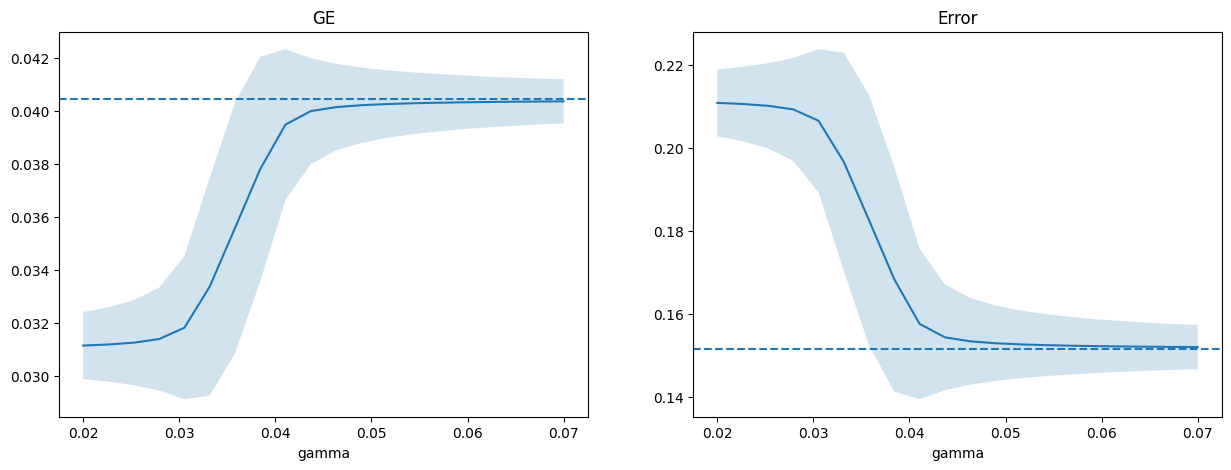

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.typing import NDArray

from datasets.adult import Adult
from fermge import BinaryLogisticClassification, ParamSet, run_exp

group_size = 2
blc_max_iter = 100
param_dict = {
    "lambda_max": [20.0],
    "nu": [0.01],
    "alpha": [0.0],
    "gamma": np.linspace(0.02, 0.07, 20).tolist(),
    "c": [8.0],
    "a": [5.0],
}

adult = Adult()
adult.download()
adult.load(group_size=group_size)

train_X: NDArray[np.float_]
train_y: NDArray[np.float_]
train_group_indices: dict[str, NDArray[np.intp]]
train_X, train_y = adult.train_data
train_group_indices = adult.train_group_indices

valid_X: NDArray[np.float_]
valid_y: NDArray[np.float_]
valid_groups: dict[str, NDArray[np.intp]]
valid_X, valid_y = adult.valid_data
valid_group_indices = adult.valid_group_indices

classifier = BinaryLogisticClassification(max_iter=blc_max_iter)
classifier.train(train_X, train_y)
classifier.valid(valid_X, valid_y)
classifier.set_group(train_group_indices, valid_group_indices)

results = run_exp(classifier, param_dict, keep_trace=False)

param_sets_by_no_gamma_key: dict[
    tuple[float, ...],  # (lambda_max, nu, alpha, c, a) "no-gamma-key"
    list[ParamSet],  # list of param sets varying gamma
] = {}
for param_set in results.keys():
    no_gamma_key = (param_set.lambda_max, param_set.nu, param_set.alpha, param_set.c, param_set.a)
    if no_gamma_key not in param_sets_by_no_gamma_key:
        param_sets_by_no_gamma_key[no_gamma_key] = []
    param_sets_by_no_gamma_key[no_gamma_key].append(param_set)

for (lambda_max, nu, alpha, c, a), param_sets_varying_gamma in param_sets_by_no_gamma_key.items():
    assert len(param_sets_varying_gamma) > 0

    gamma_list: list[float] = []
    ge_baseline: float = 0.0
    ge_mean_list: list[float] = []
    ge_std_list: list[float] = []
    err_baseline: float = 0.0
    err_mean_list: list[float] = []
    err_std_list: list[float] = []

    for param_set in param_sets_varying_gamma:
        result_valid = results[param_set][1]
        assert result_valid is not None

        gamma_list.append(param_set.gamma)

        ge_baseline = result_valid.ge_baseline
        err_baseline = result_valid.err_baseline

        ge_mean_list.append(result_valid.ge[0])
        ge_std_list.append(result_valid.ge[1])
        err_mean_list.append(result_valid.err[0])
        err_std_list.append(result_valid.err[1])

    print(f"=== lambda_max={lambda_max}, nu={nu}, alpha={alpha}, c={c}, a={a} ===")
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].plot(gamma_list, ge_mean_list)
    ax[0].fill_between(
        gamma_list,
        np.array(ge_mean_list) - np.array(ge_std_list),
        np.array(ge_mean_list) + np.array(ge_std_list),
        alpha=0.2,
    )
    ax[0].axhline(y=ge_baseline, linestyle="--")
    ax[0].set_xlabel("gamma")
    ax[0].title.set_text("GE")
    ax[1].plot(gamma_list, err_mean_list)
    ax[1].fill_between(
        gamma_list,
        np.array(err_mean_list) - np.array(err_std_list),
        np.array(err_mean_list) + np.array(err_std_list),
        alpha=0.2,
    )
    ax[1].axhline(y=err_baseline, linestyle="--")
    ax[1].set_xlabel("gamma")
    ax[1].title.set_text("Error")
    plt.show()